If your data is bad, your machine learning tools are bad.

# OUTLIERS (AYKIRI DEGER YAKALAMA)

In [1]:
# Import libraries
!pip install missingno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [3]:
# Load and read dataset
dataset = sns.load_dataset("titanic")

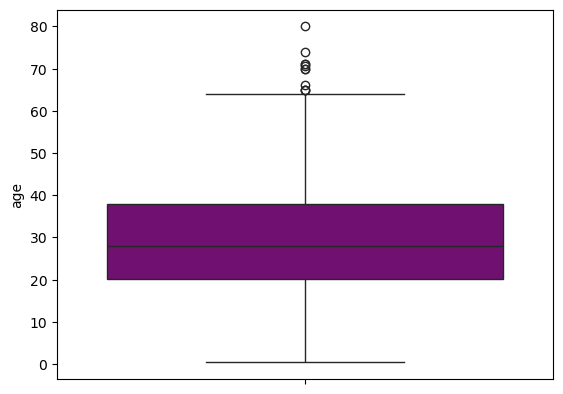

In [4]:
sns.boxplot(dataset["age"], color="purple")
plt.show()

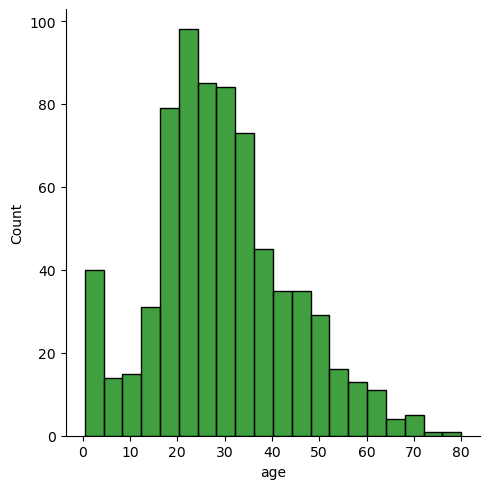

In [5]:
sns.displot(dataset["age"], color="green")
plt.show()

In [6]:
quantile1 = dataset["age"].quantile(0.25)
quantile3 = dataset["age"].quantile(0.75)
iqr = quantile3 - quantile1

up_limit = quantile3 + 1.5 * iqr
low_limit = quantile1 - 1.5 * iqr

print(f"Low limit: {low_limit}, Up limit: {up_limit}, IQR: {iqr}, Quantile (%25): {quantile1}, Quantile (%75): {quantile3}")

Low limit: -6.6875, Up limit: 64.8125, IQR: 17.875, Quantile (%25): 20.125, Quantile (%75): 38.0


In [7]:
print(dataset[(dataset["age"] < low_limit)])
print("\n--------------------------\n")
print(dataset[(dataset["age"] < low_limit)].index)
print("\n--------------------------\n")
# print(dataset[(dataset["age"] < low_limit)].any(axis=None))

Empty DataFrame
Columns: [survived, pclass, sex, age, sibsp, parch, fare, embarked, class, who, adult_male, deck, embark_town, alive, alone]
Index: []

--------------------------

Index([], dtype='int64')

--------------------------



In [8]:
print(dataset[(dataset["age"] > up_limit)])
print("\n--------------------------\n")
print(dataset[(dataset["age"] > up_limit)].index)
print("\n--------------------------\n")
# print(dataset[(dataset["age"] > up_limit)].any(axis=None))

     survived  pclass   sex    age  sibsp  parch   fare embarked   class  who  adult_male deck  embark_town alive  alone
33          0       2  male 66.000      0      0 10.500        S  Second  man        True  NaN  Southampton    no   True
54          0       1  male 65.000      0      1 61.979        C   First  man        True    B    Cherbourg    no  False
96          0       1  male 71.000      0      0 34.654        C   First  man        True    A    Cherbourg    no   True
116         0       3  male 70.500      0      0  7.750        Q   Third  man        True  NaN   Queenstown    no   True
280         0       3  male 65.000      0      0  7.750        Q   Third  man        True  NaN   Queenstown    no   True
456         0       1  male 65.000      0      0 26.550        S   First  man        True    E  Southampton    no   True
493         0       1  male 71.000      0      0 49.504        C   First  man        True  NaN    Cherbourg    no   True
630         1       1  male 80.0

In [9]:
print(dataset[(dataset["age"] < low_limit) | (dataset["age"] > up_limit)])
print("\n--------------------------\n")
print(dataset[(dataset["age"] < low_limit) | (dataset["age"] > up_limit)].index)
print("\n--------------------------\n")
# print(dataset[(dataset["age"] < low_limit) | (dataset["age"] > up_limit)].any())

     survived  pclass   sex    age  sibsp  parch   fare embarked   class  who  adult_male deck  embark_town alive  alone
33          0       2  male 66.000      0      0 10.500        S  Second  man        True  NaN  Southampton    no   True
54          0       1  male 65.000      0      1 61.979        C   First  man        True    B    Cherbourg    no  False
96          0       1  male 71.000      0      0 34.654        C   First  man        True    A    Cherbourg    no   True
116         0       3  male 70.500      0      0  7.750        Q   Third  man        True  NaN   Queenstown    no   True
280         0       3  male 65.000      0      0  7.750        Q   Third  man        True  NaN   Queenstown    no   True
456         0       1  male 65.000      0      0 26.550        S   First  man        True    E  Southampton    no   True
493         0       1  male 71.000      0      0 49.504        C   First  man        True  NaN    Cherbourg    no   True
630         1       1  male 80.0

Not: Info methodu eger kategorik verilere uygulanmaya calisilirsa hata verir sadece boolean ve sayisal veriler icindir

In [10]:
def outlier_tresholds(dataset : str, col_name : str, quantile1 : float = 0.25, quantile3 : float = 0.75):

    """
        Parameters:
            dataset,
            column name
            quantile 1 float default 25
            quantile 3 float default 75|


        Description:
            It helps to calculate low and up limit of your dataset
    """

    dataset_quantile1 = dataset[col_name].quantile(quantile1)
    dataset_quantile3 = dataset[col_name].quantile(quantile3)

    interquantile_range = dataset_quantile3 - dataset_quantile1

    up_limit = dataset_quantile3 + 1.5 * interquantile_range
    low_limit = dataset_quantile1 - 1.5 * interquantile_range

    return low_limit, up_limit

In [11]:
outlier_tresholds(dataset, "age")

(-6.6875, 64.8125)

In [12]:
def check_outlier(dataset : str, col_name : str):

    """
        Parameters:
            dataset,
            column name



        Description:
            It helps to see outliers
    """

    low, up = outlier_tresholds(dataset, col_name)

    if len(dataset[(dataset[col_name] < low) | (dataset[col_name] > up)]) > 0:
        return True

    else:
        return False

In [13]:
check_outlier(dataset, "age")

True

## Script level grab cols

- numeric, numeric but categoric, categoric but cardinal, categoric

In [14]:
def grab_col_names(dataframe, cat_th : int = 10, car_th : int = 20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, default = 10
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, default = 20
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [15]:
cat_cols, num_cols, cat_but_car = grab_col_names(dataset)

Observations: 891
Variables: 15
cat_cols: 13
num_cols: 2
cat_but_car: 0
num_but_cat: 8


In [16]:
cat_cols, num_cols, cat_but_car

(['sex',
  'embarked',
  'who',
  'embark_town',
  'alive',
  'survived',
  'pclass',
  'sibsp',
  'parch',
  'class',
  'adult_male',
  'deck',
  'alone'],
 ['age', 'fare'],
 [])

In [17]:
def grab_outliers(dataframe : str, col_name : str , index=False):
    low, up = outlier_tresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[col_name].head())
        
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [18]:
outliers_index = grab_outliers(dataset, "age", True)
outliers_index

0   22.000
1   38.000
2   26.000
3   35.000
4   35.000
Name: age, dtype: float64


Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [19]:
grab_outliers(dataset, "age")

0   22.000
1   38.000
2   26.000
3   35.000
4   35.000
Name: age, dtype: float64
